# MNIST digits classification dataset
This is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images

In [1]:
# import required library
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

## pipeline

In [8]:
# load the dataset
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()


the MNIST trainin se contains 60000 gray scale images each 28x28 pixels:

In [9]:
X_train_full.shape

(60000, 28, 28)

each pixel is represented as a byte (0 to 255)

In [10]:
X_train_full.dtype

dtype('uint8')

**split the training set into validation set and (smaller) training set.**
This is essential to efficiently validate and evaluate the model's performance, hyperparameter tuning and model selection

In [11]:
X_valid, X_train = X_train_full[:5000]/255. , X_train_full[5000:]/255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test/255.

**visualize the data**

let's plot the image using Matplotlib's `imshow()`, with a `'binary'` color map

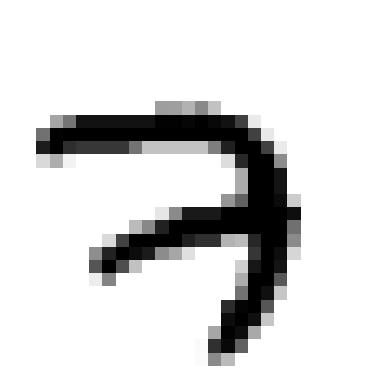

In [12]:
plt.imshow(X_train[0], cmap="binary")

plt.axis('off')
plt.show()

the labels are the class IDs(represented as uinit8) from 0 to 9. Conviniently, the classIDs correspond to the digit represented in the images, so `class_names` array is not needed

In [7]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

The validation set contains 5000 images and the test set contains 10000 images:

In [8]:
X_valid.shape

(5000, 28, 28)

In [9]:
X_test.shape

(10000, 28, 28)

sample of images in the dataset

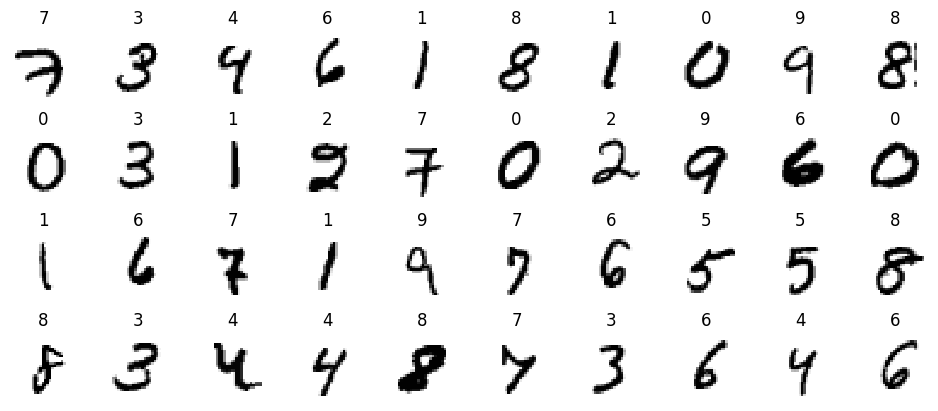

In [10]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()    

### Hyperparameter Tuning: finding the optimal learning rate

to find the optimal learningrate I used callback to grow the learning rate with each iteration and record the learning rate and loss at each iteration

In [11]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        # Get the current learning rate value

        lr = K.get_value(self.model.optimizer.learning_rate)
        # Append the current learning rate and loss to the history
        self.rates.append(lr)
        self.losses.append(logs["loss"])
        new_lr = lr * self.factor
        self.model.optimizer.learning_rate = new_lr


### create model

In [12]:
# clear previous running sessions
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [13]:
#input_ = input_shape=[28,28]
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

/Users/faithokoth/Desktop/UOL/machhine_learning/ML-Capstone_projects/MNIST-Digits_Classification/env/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 ### compile fit and train the model
 i started by traing the model with a small learning rate of 1e-3, then grew it by 0.5% at each iteration:

In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

In [15]:

history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - accuracy: 0.5390 - loss: nan - val_accuracy: 0.0958 - val_loss: nan


View loss as a functionof the learning rate graph:

In [16]:
# print(len(expon_lr.losses))
print(len(expon_lr.rates))

1719


Text(0, 0.5, 'Loss')

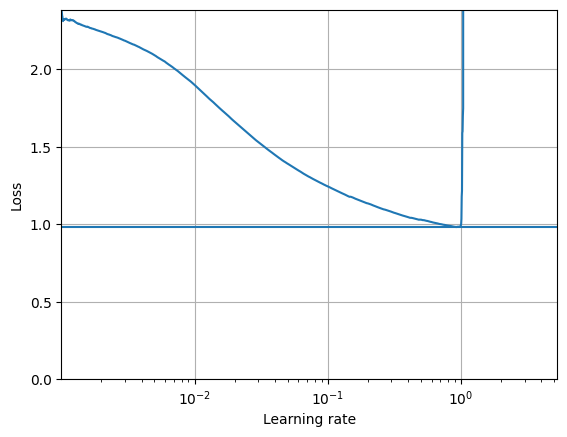

In [17]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')    
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

from the data, the loss starts shooting back when the learning rate goes over 6e-1, so we try half of it:

In [18]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])


In [20]:
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [21]:
run_index = 1 # increment with every run
run_logdir = Path() / "my_mnist_logs"/"run_{:03d}".format(run_index)
run_logdir

PosixPath('my_mnist_logs/run_001')

In [22]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model.keras", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])


Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step - accuracy: 0.8702 - loss: 0.4055 - val_accuracy: 0.9716 - val_loss: 0.0999
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 644us/step - accuracy: 0.9708 - loss: 0.0976 - val_accuracy: 0.9708 - val_loss: 0.0919
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 666us/step - accuracy: 0.9799 - loss: 0.0629 - val_accuracy: 0.9764 - val_loss: 0.0803
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 654us/step - accuracy: 0.9869 - loss: 0.0418 - val_accuracy: 0.9782 - val_loss: 0.0813
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 643us/step - accuracy: 0.9902 - loss: 0.0306 - val_accuracy: 0.9760 - val_loss: 0.0932
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/step - accuracy: 0.9924 - loss: 0.0250 - val_accuracy: 0.9800 - val_loss: 0.0828
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 644us/step - accuracy: 0.9901 - loss: 0.0264 - val_accuracy: 0.9770 - val_loss: 0.0955
Epoch 8/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 651us/step - accuracy: 

### evaluate the model

In [23]:
model = tf.keras.models.load_model("my_mnist_model.keras") # rollback to the best model
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - accuracy: 0.9702 - loss: 0.0972


[0.08024173229932785, 0.9753000140190125]

In [ ]:
!tensorboard --logdir=./my_mnist_logs

W0816 07:41:50.816634 6156021760 plugin_event_accumulator.py:369] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0816 07:41:50.818123 6156021760 plugin_event_accumulator.py:369] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0816 07:41:50.819266 6156021760 plugin_event_accumulator.py:369] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0816 07:41:50.820322 6156021760 plugin_event_accumulator.py:369] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0816 07:41:50.821981 6156021760 plugin_even

### Hyperparameter optimization using Random search

Random search is an approach to parameter tuning that will sample algorithm parameters from a random distribution (i.e. uniform) for a fixed number of iterations. A model is constructed and evaluated for each combination of parameters chosen

For this model, the following hypwerparameters were used:
- learning_rate
- number of hidden layers
- number of neurons per layer
- type of optimizers

the `keras_tuner` was used

In [5]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-6, max_value=1e-3, sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())

    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))

    model.add(tf.keras.layers.Dense(10, activation="softmax"))  # Assuming 10 classes for output layer

    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model


In [13]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="mnist_dir", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid))



Trial 5 Complete [00h 00m 07s]
val_accuracy: 0.16359999775886536

Best val_accuracy So Far: 0.9782000184059143
Total elapsed time: 00h 00m 40s


In [15]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

/Users/faithokoth/Desktop/UOL/machhine_learning/ML-Capstone_projects/MNIST-Digits_Classification/env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values